# Example PVPRO run with synthetic data

This notebook generates a PV dataset from an NSRDB weather data file. The dataset is generated by specifying rates of change of single diode model parameters, so the ground truth is known. The simulation adds noise to the measured module temperature and plane-of-array irradiance in order to make a more realistic dataset.

Using the sythetic data, the PVPRO method is used to extract single diode model parameters vs. time. The results are compared to the ground truth.

## Imports

In [26]:
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import sys
import os

# ADD pvpro module to path.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from pvpro import PvProHandler
from pvpro.preprocess import Preprocessor
from pvpro.postprocess import analyze_yoy
from pvpro.plotting import plot_results_timeseries

from pvpro.singlediode import calculate_temperature_coeffs, pvlib_single_diode
from pvlib.temperature import sapm_module, sapm_cell

## Generate Synthetic Data

Load data

In [3]:
import inspect
import pvpro
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)
pvpro_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvpro)))
filename =  os.path.join(pvpro_abspath,'data','NSRDB_data_compressed_123796_37.89_-122.26.npz')
data = np.load(filename)

In [4]:
data.files

['Source',
 'Location_ID',
 'Latitude',
 'Longitude',
 'Elevation',
 'local_time_zone',
 'interval_in_hours',
 'timedelta_in_years',
 'Version',
 'dni',
 'dhi',
 'ghi',
 'temp_air',
 'wind_speed',
 'year',
 'month',
 'day',
 'hour',
 'minute']

In [5]:
df = pd.DataFrame({'dni': data['dni'],
                   'ghi': data['ghi'],
                   'temperature_air': data['temp_air'],
                   'wind_speed': data['wind_speed'],
                   'year': data['year'],
                   'month': data['month'],
                   'day': data['day'],
                   'hour': data['hour'],
                   'minute': data['minute']
                   })

df.index = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

# # Clip shorter
df = df[:'2002-01-01']

# 15 minute interpolation
df = df.resample('15T').interpolate('linear')

# drop times when GHI is <= 1
df.drop(df.index[df['ghi'] <= 1.], inplace=True)

# assume poa = ghi, e.g., horizontal module
df['poa_actual'] = df['ghi']

# Calculate true module/cell temperature
df['temperature_module_actual'] = sapm_module(
    poa_global=df['poa_actual'],
    temp_air=df['temperature_air'],
    wind_speed=df['wind_speed'],
    a=-3.56,
    b=-0.075
)

df['temperature_cell_actual'] = sapm_cell(
    poa_global=df['poa_actual'],
    temp_air=df['temperature_air'],
    wind_speed=df['wind_speed'],
    a=-3.56,
    b=-0.075,
    deltaT=3)

In [6]:
df

,dni,ghi,temperature_air,wind_speed,year,month,day,hour,minute,poa_actual,temperature_module_actual,temperature_cell_actual
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114
1998-01-01 08:00:00,177.0,47.0,10.0,2.300781,1998.0,1.0,1.0,8.0,0.0,47.0,11.125229,11.266229
1998-01-01 08:15:00,238.0,77.0,10.0,2.351562,1998.0,1.0,1.0,8.0,15.0,77.0,11.835236,12.066236
1998-01-01 08:30:00,299.0,107.0,10.0,2.400391,1998.0,1.0,1.0,8.0,30.0,107.0,12.540466,12.861466
1998-01-01 08:45:00,165.5,104.0,10.5,2.500000,1998.0,1.0,1.0,8.5,15.0,104.0,12.950195,13.262195
...,...,...,...,...,...,...,...,...,...,...,...,...
2002-01-01 15:45:00,0.0,60.5,13.0,2.750000,2002.0,1.0,1.0,15.5,15.0,60.5,14.397659,14.579159
2002-01-01 16:00:00,0.0,44.0,13.0,2.800781,2002.0,1.0,1.0,16.0,0.0,44.0,14.012451,14.144451
2002-01-01 16:15:00,0.0,30.5,13.0,2.800781,2002.0,1.0,1.0,16.0,15.0,30.5,13.701813,13.793313
2002-01-01 16:30:00,0.0,17.0,13.0,2.800781,2002.0,1.0,1.0,16.0,30.0,17.0,13.391174,13.442174


Simulate some noise on the "measured" poa irradiance by multiplying Gaussian noise with the "actual" poa irradiance.

In [7]:
# Fractional POA noise standard deviation. 
poa_noise_level = 0.02

# Seed random generator to get same results each time.
np.random.seed(0)
df['poa_meas'] = df['poa_actual'] * np.random.normal(1, poa_noise_level, len(df))


The "measured" module temperature is created by adding normally distributed noise to the "actual" module temperature.

In [8]:
# Temperature noise standard deviation in C.
temperature_noise_level = 1.0

df['temperature_module_meas'] = df['temperature_module_actual'] + \
        np.random.normal(0,temperature_noise_level, len(df))


In [9]:
np.random.normal(0,temperature_noise_level, len(df))

array([-0.63058801, -0.62820567,  0.13421514, ..., -0.47944271,
       -0.81992813,  1.2330813 ])

In [10]:
df

,dni,ghi,temperature_air,wind_speed,year,month,day,hour,minute,poa_actual,temperature_module_actual,temperature_cell_actual,poa_meas,temperature_module_meas
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452
1998-01-01 08:00:00,177.0,47.0,10.0,2.300781,1998.0,1.0,1.0,8.0,0.0,47.0,11.125229,11.266229,47.376148,12.294852
1998-01-01 08:15:00,238.0,77.0,10.0,2.351562,1998.0,1.0,1.0,8.0,15.0,77.0,11.835236,12.066236,78.507256,11.415333
1998-01-01 08:30:00,299.0,107.0,10.0,2.400391,1998.0,1.0,1.0,8.0,30.0,107.0,12.540466,12.861466,111.795511,12.896238
1998-01-01 08:45:00,165.5,104.0,10.5,2.500000,1998.0,1.0,1.0,8.5,15.0,104.0,12.950195,13.262195,107.884521,12.461114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-01-01 15:45:00,0.0,60.5,13.0,2.750000,2002.0,1.0,1.0,15.5,15.0,60.5,14.397659,14.579159,61.119208,14.038063
2002-01-01 16:00:00,0.0,44.0,13.0,2.800781,2002.0,1.0,1.0,16.0,0.0,44.0,14.012451,14.144451,44.274636,12.566506
2002-01-01 16:15:00,0.0,30.5,13.0,2.800781,2002.0,1.0,1.0,16.0,15.0,30.5,13.701813,13.793313,30.255964,13.918058
2002-01-01 16:30:00,0.0,17.0,13.0,2.800781,2002.0,1.0,1.0,16.0,30.0,17.0,13.391174,13.442174,16.739329,12.616082


In [11]:

def step_change(start_val, end_val, t_years, t_step=2):
    """
    Create a smooth step change time series. 
    """
    y = np.zeros_like(t_years) + start_val
    y = y + (end_val - start_val) * (
            np.arctan(10 * (t_years - 2)) / np.pi + 0.5)
    return y


In [12]:
q = 1.60218e-19  # Elementary charge in units of coulombs
kb = 1.38066e-23  # Boltzmann's constant in units of J/K

# time vector in years
t_years = (df.index - df.index[0]).days / 365

Set the parameters and how they change with time.

In [13]:
df['cells_in_series'] = 60
df['alpha_sc'] = 0.001
df['diode_factor'] = 1.2 - 0.0 * t_years
df['nNsVth_ref'] = df['diode_factor'] * df['cells_in_series'] * kb / q * (
        273.15 + 25)
df['photocurrent_ref'] = 6.0 - (0.1 * t_years - 0.05 * np.sin(2 * np.pi * t_years))
df['saturation_current_ref'] = 1e-10 + 0.5e-9 * t_years
# df['resistance_shunt_ref'] = step_change(1000, 100, t_years, 2)
df['resistance_shunt_ref'] = 1e12
df['conductance_shunt_extra'] = 0.000 + 0.0003 * t_years
df['resistance_series_ref'] = step_change(0.35, 0.7, t_years)
# df['resistance_series_ref'] = 0.35
df['band_gap_ref'] = 1.121
df['dEgdT'] = -0.0002677

In [14]:
df

,dni,ghi,temperature_air,wind_speed,year,month,day,hour,minute,poa_actual,temperature_module_actual,temperature_cell_actual,poa_meas,temperature_module_meas,cells_in_series,alpha_sc,diode_factor,nNsVth_ref,photocurrent_ref,saturation_current_ref,resistance_shunt_ref,conductance_shunt_extra,resistance_series_ref,band_gap_ref,dEgdT
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.000000,1.000000e-10,1.000000e+12,0.000000,0.355566,1.121,-0.000268
1998-01-01 08:00:00,177.0,47.0,10.0,2.300781,1998.0,1.0,1.0,8.0,0.0,47.0,11.125229,11.266229,47.376148,12.294852,60,0.001,1.2,1.849877,6.000000,1.000000e-10,1.000000e+12,0.000000,0.355566,1.121,-0.000268
1998-01-01 08:15:00,238.0,77.0,10.0,2.351562,1998.0,1.0,1.0,8.0,15.0,77.0,11.835236,12.066236,78.507256,11.415333,60,0.001,1.2,1.849877,6.000000,1.000000e-10,1.000000e+12,0.000000,0.355566,1.121,-0.000268
1998-01-01 08:30:00,299.0,107.0,10.0,2.400391,1998.0,1.0,1.0,8.0,30.0,107.0,12.540466,12.861466,111.795511,12.896238,60,0.001,1.2,1.849877,6.000000,1.000000e-10,1.000000e+12,0.000000,0.355566,1.121,-0.000268
1998-01-01 08:45:00,165.5,104.0,10.5,2.500000,1998.0,1.0,1.0,8.5,15.0,104.0,12.950195,13.262195,107.884521,12.461114,60,0.001,1.2,1.849877,6.000000,1.000000e-10,1.000000e+12,0.000000,0.355566,1.121,-0.000268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-01-01 15:45:00,0.0,60.5,13.0,2.750000,2002.0,1.0,1.0,15.5,15.0,60.5,14.397659,14.579159,61.119208,14.038063,60,0.001,1.2,1.849877,5.600587,2.101370e-09,1.000000e+12,0.001201,0.694442,1.121,-0.000268
2002-01-01 16:00:00,0.0,44.0,13.0,2.800781,2002.0,1.0,1.0,16.0,0.0,44.0,14.012451,14.144451,44.274636,12.566506,60,0.001,1.2,1.849877,5.600587,2.101370e-09,1.000000e+12,0.001201,0.694442,1.121,-0.000268
2002-01-01 16:15:00,0.0,30.5,13.0,2.800781,2002.0,1.0,1.0,16.0,15.0,30.5,13.701813,13.793313,30.255964,13.918058,60,0.001,1.2,1.849877,5.600587,2.101370e-09,1.000000e+12,0.001201,0.694442,1.121,-0.000268
2002-01-01 16:30:00,0.0,17.0,13.0,2.800781,2002.0,1.0,1.0,16.0,30.0,17.0,13.391174,13.442174,16.739329,12.616082,60,0.001,1.2,1.849877,5.600587,2.101370e-09,1.000000e+12,0.001201,0.694442,1.121,-0.000268


In [15]:
df.loc[df.index.day==1].head()

,dni,ghi,temperature_air,wind_speed,year,month,day,hour,minute,poa_actual,temperature_module_actual,temperature_cell_actual,poa_meas,temperature_module_meas,cells_in_series,alpha_sc,diode_factor,nNsVth_ref,photocurrent_ref,saturation_current_ref,resistance_shunt_ref,conductance_shunt_extra,resistance_series_ref,band_gap_ref,dEgdT
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268
1998-01-01 08:00:00,177.0,47.0,10.0,2.300781,1998.0,1.0,1.0,8.0,0.0,47.0,11.125229,11.266229,47.376148,12.294852,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268
1998-01-01 08:15:00,238.0,77.0,10.0,2.351562,1998.0,1.0,1.0,8.0,15.0,77.0,11.835236,12.066236,78.507256,11.415333,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268
1998-01-01 08:30:00,299.0,107.0,10.0,2.400391,1998.0,1.0,1.0,8.0,30.0,107.0,12.540466,12.861466,111.795511,12.896238,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268
1998-01-01 08:45:00,165.5,104.0,10.5,2.500000,1998.0,1.0,1.0,8.5,15.0,104.0,12.950195,13.262195,107.884521,12.461114,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268


In [16]:
len(df)

70373

In [17]:
# Calculate module operation over time.
out = pvlib_single_diode(
    effective_irradiance=df['poa_actual'],
    temperature_cell=df['temperature_cell_actual'],
    resistance_shunt_ref=df['resistance_shunt_ref'],
    resistance_series_ref=df['resistance_series_ref'],
    diode_factor=df['diode_factor'],
    cells_in_series=df['cells_in_series'],
    alpha_isc=df['alpha_sc'],
    photocurrent_ref=df['photocurrent_ref'],
    saturation_current_ref=df['saturation_current_ref'],
    Eg_ref=df['band_gap_ref'],
    dEgdT=df['dEgdT'],
    conductance_shunt_extra=df['conductance_shunt_extra'],
    singlediode_method='newton',
    ivcurve_pnts=None,
)

# Add to the dataframe
for k in out.keys():
    df[k] = out[k]

# Calculate module reference conditions over time.
out_ref = pvlib_single_diode(
    effective_irradiance=1000,
    temperature_cell=25,
    resistance_shunt_ref=df['resistance_shunt_ref'],
    resistance_series_ref=df['resistance_series_ref'],
    diode_factor=df['diode_factor'],
    cells_in_series=df['cells_in_series'],
    alpha_isc=df['alpha_sc'],
    photocurrent_ref=df['photocurrent_ref'],
    saturation_current_ref=df['saturation_current_ref'],
    Eg_ref=df['band_gap_ref'],
    dEgdT=df['dEgdT'],
    conductance_shunt_extra=df['conductance_shunt_extra'],
    singlediode_method='newton',
    ivcurve_pnts=None,
)

for k in out_ref.keys():
    df[k + '_ref'] = out_ref[k]

# Set DC operation point at MPP
# Add gausian nosie

df['v_dc'] = df['v_mp'] + np.random.normal(0, 2, len(df))
df['i_dc'] = df['i_mp'] + np.random.normal(0, 0.5, len(df))

# add abnormal IV
ab_v_inx = np.random.choice(len(df), int(len(df)/100))
ab_i_inx = np.random.choice(len(df), int(len(df)/200))
df['v_dc'].iloc[ab_v_inx] = df['v_mp'][ab_v_inx] + np.random.normal(100, 5, len(ab_v_inx))
df['i_dc'].iloc[ab_i_inx] = df['v_mp'][ab_i_inx] + np.random.normal(50, 5, len(ab_i_inx))

# Change DC operation point to Voc during low irradiance conditions
df.loc[df['poa_actual'] < 50, 'v_dc'] = df.loc[
    df['poa_actual'] < 50, 'v_oc']
df.loc[df['poa_actual'] < 50, 'i_dc'] = 0


df.loc[df.index.day==1, 'v_dc'] = df.loc[df.index.day==1, 'v_oc']
df.loc[df.index.day==1, 'i_dc'] = 0


# Save data
# df.to_pickle('synth01_out.pkl')
print('done!')

done!


/Users/XChen9/anaconda3/envs/pvpro/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [18]:
df['i_dc'].describe()

count    70373.000000
mean         2.384007
std          5.463193
min         -1.535404
25%          0.456677
50%          1.766299
75%          3.444009
max         99.382734
Name: i_dc, dtype: float64

## Run Preprocess.

Load preprocessor

In [23]:
pre = Preprocessor(df,
                   voltage_dc_key='v_dc',
                   current_dc_key='i_dc',
                   temperature_module_key='temperature_module_meas',
                   irradiance_poa_key='poa_meas',
                   modules_per_string=1,
                   parallel_strings=1,
                   )

Calculate cell temperature from module temperature and POA.

In [24]:
pre.calculate_cell_temperature(delta_T=3)

Cell temperature assigned to 'temperature_cell'


Two preprocessing modes, 'fast' and 'sdt'. Since this is clean synthetic data, we will use the 'fast' pipeline.

In [25]:
method='sdt'
if method=='sdt':
    pre.run_preprocess_sdt(correct_dst=True, verbose=False)
    pre.classify_points_sdt()
    pre.build_operating_cls()

elif method=='fast':
    pre.classify_points_pva()
    pre.build_operating_cls()

In [168]:
pre.df.head()

,dni,ghi,temperature_air,wind_speed,year,month,day,hour,minute,poa_actual,temperature_module_actual,temperature_cell_actual,poa_meas,temperature_module_meas,cells_in_series,alpha_sc,diode_factor,nNsVth_ref,photocurrent_ref,saturation_current_ref,resistance_shunt_ref,conductance_shunt_extra,resistance_series_ref,band_gap_ref,dEgdT,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx,i_sc_ref,v_oc_ref,i_mp_ref,v_mp_ref,p_mp_ref,i_x_ref,i_xx_ref,v_dc,i_dc,seq_index,temperature_cell,power_dc,daytime,clipped_times,high_v,low_p,no_errors,missing_data,operating_cls
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,0,9.882439,0.0,False,False,True,True,False,False,-2
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,0,9.882439,0.0,False,False,True,True,False,False,-2
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,0,9.882439,0.0,False,False,True,True,False,False,-2
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,0,9.882439,0.0,False,False,True,True,False,False,-2
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,0,9.882439,0.0,False,False,True,True,False,False,-2


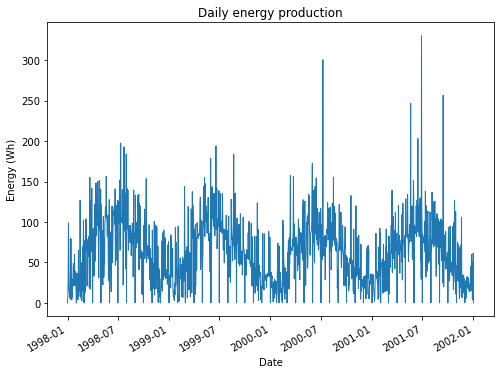

In [169]:
fig = pre.dh.plot_daily_energy()

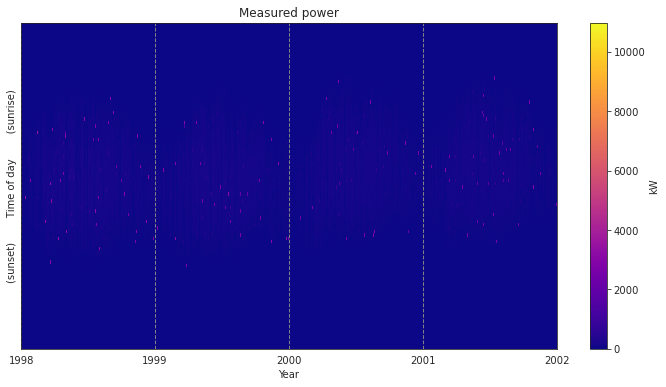

In [170]:
if method=='sdt':
    fig = pre.dh.plot_heatmap('filled')

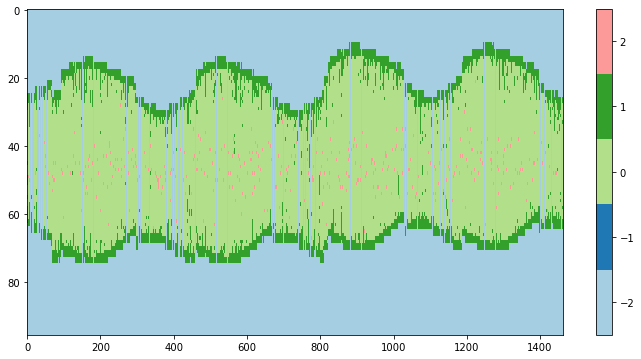

In [171]:
if method=='sdt':
    fig = pre.plot_operating_cls()

In [172]:
filter_IE = pre.find_current_irradiance_outliers(points_per_iteration=5000)

In [173]:
max_k = len(filter_IE['upper_iter_idx'])
poa = pre.df[pre.irradiance_poa_key]
current = pre.df[pre.current_dc_key]/pre.parallel_strings
@interact
def show_inbounds_IE(k=(0,max_k,1)):

    k = round(k)
    cax = np.arange(filter_IE['lower_iter_idx'][k], filter_IE['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and(np.logical_not(filter_IE['outliers'][cax]), filter_IE['boolean_mask'][cax])
    outliers =  np.logical_and(filter_IE['outliers'][cax],filter_IE['boolean_mask'][cax])
    
    x_smooth = np.linspace(0,1200,5)
    fig = plt.figure()
    plt.scatter(poa[cax][inbounds],current[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_IE['huber'][k].coef_ * x_smooth + filter_IE['huber'][k].intercept_,'g')

    plt.scatter(poa[cax][outliers], current[cax][outliers], s=1,
               c='r',label='Outliers')
    plt.xlabel('POA (W/m^2)')
    plt.ylabel('Current (A)')
    plt.xlim([0,1200])
    plt.ylim([0,11])
    plt.legend()
    plt.show()


interactive(children=(IntSlider(value=25, description='k', max=50), Output()), _dom_classes=('widget-interact'…

In [174]:
filter_TV = pre.find_temperature_voltage_outliers(voltage_lower_lim=0,
                                                  poa_lower_lim=200,
                                                  points_per_iteration=100000,
                                                 epsilon=3)

In [175]:
max_k = len(filter_TV['upper_iter_idx'])-1
poa = pre.df[pre.irradiance_poa_key]
current = pre.df[pre.current_dc_key]/pre.parallel_strings
voltage = pre.df[pre.voltage_dc_key]/pre.modules_per_string
temperature_cell = pre.df['temperature_cell']
@interact
def show_inbounds_TV(k=(0,max_k,1)):

    k = round(k)
    cax = np.arange(filter_TV['lower_iter_idx'][k], filter_TV['upper_iter_idx'][k]).astype('int')

    inbounds =  np.logical_and.reduce((
        np.logical_not(filter_TV['outliers'][cax]),
        filter_TV['boolean_mask'][cax]
    ))
    outliers =  np.logical_and(filter_TV['outliers'][cax],        filter_TV['boolean_mask'][cax])
    
    x_smooth = np.linspace(0,70,2)
    fig = plt.figure()
    plt.scatter(temperature_cell[cax][inbounds],voltage[cax][inbounds],s=1,c='b',label='Points to use')
    plt.plot(x_smooth, filter_TV['huber'][k].coef_ * x_smooth + filter_TV['huber'][k].intercept_,'g')
    print(filter_TV['huber'][k].coef_)

    plt.scatter(temperature_cell[cax][outliers], voltage[cax][outliers], s=1,
               c='r',label='Outliers')
    plt.xlabel('Cell Temperature (C)')
    plt.ylabel('Voltage (V)')
    plt.xlim([-20,70])
    plt.ylim([0,70])
    plt.legend()
    plt.show()


interactive(children=(IntSlider(value=0, description='k', max=1), Output()), _dom_classes=('widget-interact',)…

In [176]:
pre.df.loc[pre.df['i_dc'].idxmax(), :]

dni                                        91.0
ghi                                       157.0
temperature_air                            13.0
wind_speed                             0.700195
year                                     1998.0
month                                      11.0
day                                        16.0
hour                                       15.0
minute                                      0.0
poa_actual                                157.0
temperature_module_actual             17.233078
temperature_cell_actual               17.704078
poa_meas                             161.611856
temperature_module_meas                16.76393
cells_in_series                              60
alpha_sc                                  0.001
diode_factor                                1.2
nNsVth_ref                             1.849877
photocurrent_ref                        5.87702
saturation_current_ref                      0.0
resistance_shunt_ref            10000000

Make PvProHandler object to store data and run analysis.

In [177]:
pvp = PvProHandler(pre.df,
                   system_name='synthetic',
                   cells_in_series=60,
                   resistance_shunt_ref=df['resistance_shunt_ref'].mean(),
                   alpha_isc=0.001,
                   voltage_key='v_dc',
                   current_key='i_dc',
                   temperature_cell_key='temperature_cell',
                   irradiance_poa_key='poa_meas',
                   modules_per_string=1,
                   parallel_strings=1,
                   )

In [178]:
pvp.df.head()

,dni,ghi,temperature_air,wind_speed,year,month,day,hour,minute,poa_actual,temperature_module_actual,temperature_cell_actual,poa_meas,temperature_module_meas,cells_in_series,alpha_sc,diode_factor,nNsVth_ref,photocurrent_ref,saturation_current_ref,resistance_shunt_ref,conductance_shunt_extra,resistance_series_ref,band_gap_ref,dEgdT,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx,i_sc_ref,v_oc_ref,i_mp_ref,v_mp_ref,p_mp_ref,i_x_ref,i_xx_ref,v_dc,i_dc,seq_index,temperature_cell,power_dc,daytime,clipped_times,high_v,low_p,no_errors,missing_data,operating_cls,current_irradiance_outliers,voltage_temperature_outliers
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,0,9.882439,0.0,False,False,True,True,False,False,-2,False,False
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,1,9.882439,0.0,False,False,True,True,False,False,-2,False,False
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,2,9.882439,0.0,False,False,True,True,False,False,-2,False,False
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,3,9.882439,0.0,False,False,True,True,False,False,-2,False,False
1998-01-01 07:45:00,88.5,23.5,9.5,2.300781,1998.0,1.0,1.0,7.5,15.0,23.5,10.062614,10.133114,24.329105,9.809452,60,0.001,1.2,1.849877,6.0,1.000000e-10,1.000000e+12,0.0,0.355566,1.121,-0.000268,0.140651,41.653972,0.134128,36.206518,4.856325,0.14065,0.110098,6.0,45.925981,5.708718,38.297858,218.631683,5.999922,4.266063,41.653972,0.0,4,9.882439,0.0,False,False,True,True,False,False,-2,False,False


 98%|████████████████████████████████████████ | 203/208 [00:02<00:00, 67.81it/s]

drawing figures on last iteration.


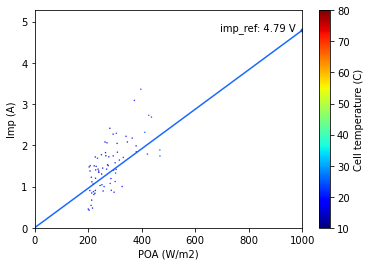

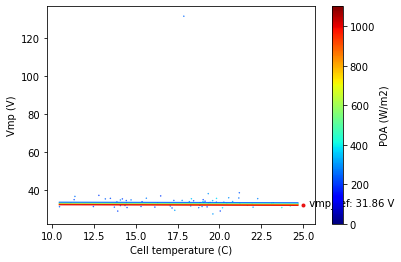

100%|█████████████████████████████████████████| 208/208 [00:03<00:00, 62.86it/s]

Elapsed time: 3 s


In [179]:
_ = pvp.quick_parameter_extraction()

In [180]:
# Estimate startpoint.
pvp.estimate_p0(
    boolean_mask=np.logical_and.reduce((
        np.logical_not(pre.df['current_irradiance_outliers']),
        np.logical_not(pre.df['clipped_times']),
        np.logical_not(pre.df['voltage_temperature_outliers']),
        pre.df['operating_cls'] == 0,
        pvp.df[pvp.irradiance_poa_key]>300,
        ))
)
# pvp.p0['diode_factor'] = 1.1
print('Estimated startpoint:')
print(pvp.p0)

Estimated startpoint:
{'diode_factor': 1.3227527144352942, 'photocurrent_ref': 5.946794764802768, 'saturation_current_ref': 5.758530509810258e-09, 'resistance_series_ref': 0.44145466837183306, 'resistance_shunt_ref': 400, 'conductance_shunt_extra': 0.0, 'v_oc_ref': 42.32797203553505, 'i_mp_ref': 5.545804526694964, 'i_sc_ref': 5.9183635850061975, 'v_mp_ref': 34.38875264314571, 'p_mp_ref': 190.71330007575085, 'alpha_isc': 0.0029724449604452024, 'alpha_imp': -0.0074709815317557425, 'beta_vmp': -0.20531524417381766, 'beta_voc': -0.20055715042417466, 'cells_in_series': 60, 'nNsVth_ref': 2.039839006809241}


Can set a custom startpoint if auto-chosen startpoint isn't great.

In [181]:
if False:
    pvp.p0 = {'diode_factor': 1.2,
          'photocurrent_ref': 5.9,
          'saturation_current_ref': 6e-9,
          'resistance_series_ref': 0.4,
          'conductance_shunt_extra': 0.001}

Plot startpoint on top of data.

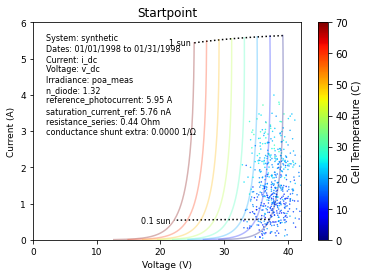

In [182]:
pvp.plot_Vmp_Imp_scatter(df=pvp.df[:5000],
                         p_plot=pvp.p0,
                         figure_number=4,
                         plot_vmp_max=42,
                         plot_imp_max=6)
plt.title('Startpoint')
plt.show()

Set boolean mask for which points to include. For this clean data, we are choosing a very simple mask. For a real PV dataset, more filtering on bad data is typically required.

In [183]:
#boolean_mask = pvp.df['poa_meas'] > 100
boolean_mask = np.logical_or.reduce((np.logical_and.reduce((
                                        np.logical_not(pre.df['current_irradiance_outliers']),
                                        np.logical_not(pre.df['clipped_times']),
                                        np.logical_not(pre.df['voltage_temperature_outliers']),
                                        pvp.df[pvp.irradiance_poa_key]>100,
#                                           pre.df['monotonic'],
                                        )),
                                     pvp.df['operating_cls']==1,
                                     pvp.df['operating_cls']==2
                                    ))


Set hyperparameters for running model.

In [184]:
# Set hyperparameters for running model.
hyperparams = {
    'use_voc_points': False,
    'use_mpp_points': True,
    'use_clip_points': False,
    'method': 'minimize',
    'solver': 'L-BFGS-B',
    # 'solver': 'nelder-mead',
    'diode_factor': pvp.p0['diode_factor'],
    'days_per_run': 30,
    'iterations_per_year': 12,
    'save_figs': False,
    'verbose' : False,
    'saturation_current_multistart':[0.7,1.0,1.3],
#     'saturation_current_multistart':[1.0],
    'start_point_method': 'last',
    'save_figs_directory': 'figures',
    'plot_imp_max': 7,
    'plot_vmp_max': 35,
    'boolean_mask': boolean_mask,
    'singlediode_method':'fast'
}

In [185]:
ret = pvp.execute(iteration='all',
                  **hyperparams)

100%|███████████████████████████████████████████| 48/48 [00:43<00:00,  1.11it/s]

Elapsed time: 0.72 min


Get results

In [186]:
pfit = pvp.result['p']
# Optional: throw away high residual "bad fit" points.
# pfit = pfit[pfit['residual']< np.percentile(pfit['residual'],90)].copy()
pfit.dropna(inplace=True)
pfit.index = pfit['t_start']

In [187]:
pfit#.head()

,t_start,t_end,diode_factor_est,photocurrent_ref_est,saturation_current_ref_est,resistance_series_ref_est,resistance_shunt_ref_est,conductance_shunt_extra_est,v_oc_ref_est,i_mp_ref_est,i_sc_ref_est,v_mp_ref_est,p_mp_ref_est,alpha_isc_est,alpha_imp_est,beta_vmp_est,beta_voc_est,cells_in_series_est,nNsVth_ref_est,photocurrent_ref,saturation_current_ref,resistance_series_ref,conductance_shunt_extra,diode_factor,resistance_shunt_ref,alpha_isc,band_gap_ref,residual,nNsVth_ref,i_sc_ref,v_oc_ref,i_mp_ref,v_mp_ref,p_mp_ref,i_x_ref,i_xx_ref,t_mean,t_years
t_start,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-01 07:45:00,1998-01-01 07:45:00,1998-01-31 07:45:00,1.087560,6.099449,8.081827e-10,0.579844,400.0,0.0,47.672087,5.688166,6.070288,38.730502,220.305510,0.003049,-0.014336,-0.201385,-0.196718,75.0,2.096431,6.092390,6.338757e-10,0.756153,0.000000,1.322753,1.000000e+12,0.001,1.121,0.090047,2.039839,6.092390,46.887695,5.732858,36.780513,210.857469,6.091795,3.911988,1998-01-16 07:45:00,1998.041068
1998-01-31 18:15:00,1998-01-31 18:15:00,1998-03-02 18:15:00,0.805835,5.969495,2.100475e-13,0.823518,400.0,0.0,45.546800,5.566974,5.940955,37.003843,205.999424,0.002984,0.070828,-0.106248,-0.103786,71.0,1.470518,6.143918,5.594891e-10,0.992390,0.000000,1.322753,1.000000e+12,0.001,1.121,0.075736,2.039839,6.143918,47.159180,5.752602,35.834041,206.138987,6.142754,3.760448,1998-02-15 18:15:00,1998.123203
1998-03-03 04:45:00,1998-03-03 04:45:00,1998-04-02 04:45:00,0.960744,6.266716,4.003770e-11,0.651625,400.0,0.0,45.819323,5.844153,6.236755,37.225251,217.550075,0.003132,-0.004828,-0.154797,-0.151210,72.0,1.777896,6.115088,1.418201e-09,0.355668,0.000000,1.322753,1.000000e+12,0.001,1.121,0.036858,2.039839,6.115088,45.252930,5.779759,37.274938,215.440148,6.114818,4.287897,1998-03-18 04:45:00,1998.208077
1998-04-02 15:15:00,1998-04-02 15:15:00,1998-05-02 15:15:00,1.037342,6.077905,2.276430e-10,0.604574,400.0,0.0,45.437433,5.668074,6.048847,36.914990,209.236881,0.003038,-0.002040,-0.174584,-0.170538,71.0,1.892981,6.039020,1.799419e-09,0.312385,0.000000,1.322753,1.000000e+12,0.001,1.121,0.024104,2.039839,6.039020,44.741211,5.708086,37.034947,211.398653,6.038757,4.280489,1998-04-17 15:15:00,1998.290212
1998-05-03 01:45:00,1998-05-03 01:45:00,1998-06-02 01:45:00,1.030816,6.098519,2.476201e-10,0.593732,400.0,0.0,44.999734,5.687298,6.069362,36.559388,207.924133,0.003048,-0.001416,-0.173707,-0.169682,71.0,1.881073,6.094884,1.522971e-09,0.485998,0.001482,1.322753,1.000000e+12,0.001,1.121,0.042543,2.039839,6.090499,45.078471,5.695171,36.455176,207.618461,6.056723,4.098365,1998-05-18 01:45:00,1998.375086
1998-06-02 12:15:00,1998-06-02 12:15:00,1998-07-02 12:15:00,0.933614,5.971221,1.858989e-11,0.676961,400.0,0.0,43.860480,5.568583,5.942673,35.633817,198.429880,0.002985,-0.001224,-0.140823,-0.137560,69.0,1.655702,5.963559,1.879784e-09,0.401040,0.000000,1.322753,1.000000e+12,0.001,1.121,0.038537,2.039839,5.963559,44.625977,5.627587,36.502875,205.423112,5.963217,4.130409,1998-06-17 12:15:00,1998.457221
1998-07-02 22:45:00,1998-07-02 22:45:00,1998-08-01 22:45:00,1.008730,5.895454,1.146745e-10,0.629007,400.0,0.0,44.111674,5.497926,5.867269,35.837896,197.034101,0.002947,0.001528,-0.161724,-0.157976,69.0,1.788917,5.976878,2.449823e-09,0.283212,0.001292,1.322753,1.000000e+12,0.001,1.121,0.016927,2.039839,5.974691,44.071890,5.604174,36.554578,204.858200,5.945946,4.234986,1998-07-17 22:45:00,1998.539357
1998-08-02 09:15:00,1998-08-02 09:15:00,1998-09-01 09:15:00,0.914754,5.870800,1.196049e-11,0.688080,400.0,0.0,43.029596,5.474934,5.842732,34.958777,191.397003,0.002934,0.000690,-0.134002,-0.130897,68.0,1.598745,5.925073,2.281161e-09,0.342371,0.000000,1.322753,1.000000e+12,0.001,1.121,0.023583,2.039839,5.925073,44.218750,5.593497,36.423082,203.732387,5.924759,4.162498,1998-08-17 09:15:00,1998.624230
1998-09-01 19:45:00,1998-09-01 19:45:00,1998-10-01 19:45:00,0.993505,5.714801,7.471277e-11,0.654115,400.0,0.0,43.506127,5.329454,5.687479,35.345928,188.374500,0.002856,0.008239,-0.

Inspect fit result

In [189]:
@interact
def inspect_results(k=(0,len(pfit),1),filter=True):

    cax = np.logical_and(
        pvp.df.index>pfit['t_start'][k],
        pvp.df.index<pfit['t_end'][k]
    )
    if filter:
        mask = boolean_mask[cax]
    else:
        mask = np.ones_like(boolean_mask[cax])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    pvp.plot_Vmp_Imp_scatter(df=pvp.df[cax][mask],
                             p_plot=pfit.iloc[k],
                            plot_vmp_max=50,
                            plot_imp_max=7)
    plt.subplot(1,2,2)
    pvp.plot_current_irradiance_mpp_scatter(df=pvp.df[cax][mask],

                                            p_plot=pfit.iloc[k],
                            plot_imp_max=7)
    plt.show()

interactive(children=(IntSlider(value=24, description='k', max=48), Checkbox(value=True, description='filter')…

Analyze year-on-year trend.

In [190]:
yoy_result = analyze_yoy(pfit)

Format ground truth data for comparison.

In [191]:
compare = pvp.df.resample('M').mean()
compare['t_years'] = np.array(
            [t.year + (t.dayofyear - 1) / 365.25 for t in compare.index])


Compare results in a plot.

0.6184848547075806


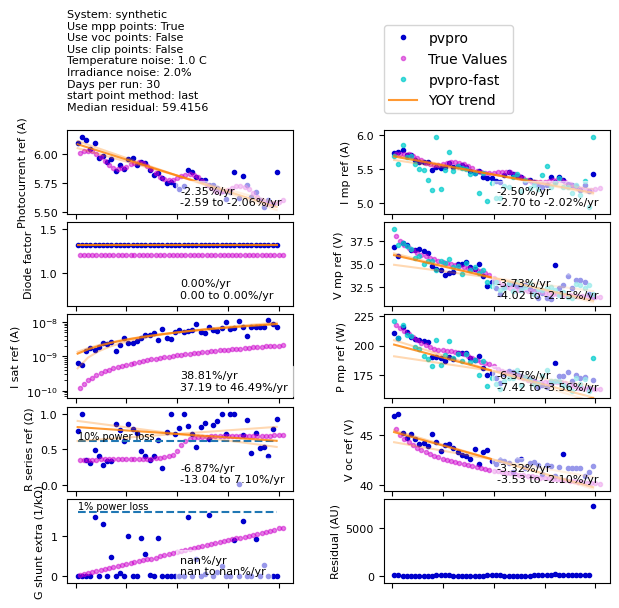

In [192]:
extra_text = 'System: {}\n'.format(pvp.system_name) + \
                 'Use mpp points: {}\n'.format(hyperparams['use_mpp_points']) + \
                 'Use voc points: {}\n'.format(hyperparams['use_voc_points']) + \
                 'Use clip points: {}\n'.format(hyperparams['use_clip_points']) + \
                 'Temperature noise: {} C\n'.format(temperature_noise_level) + \
                 'Irradiance noise: {:.1%} \n'.format(poa_noise_level) + \
                 'Days per run: {}\n'.format(hyperparams['days_per_run']) + \
                 'start point method: {}\n'.format(hyperparams['start_point_method']) + \
                 'Median residual: {:.4f}\n'.format(1000*np.median(pfit['residual']))



# Plot results
plot_results_timeseries(pfit,yoy_result=yoy_result,
                        extra_text=extra_text,
                        compare=compare)
plt.gcf().set_dpi(100)
# plt.savefig('figures/synth02_result.pdf',bbox_inches='tight')

Form comparison using rms error from extracted to true. 

In [193]:
from pvpro.postprocess import calculate_rms_error

In [194]:
rms_error = calculate_rms_error(pfit,df,zero_mean=True)

Inspect

In [195]:
pd.Series(rms_error)

diode_factor               2.434276e-15
photocurrent_ref           6.256518e-02
saturation_current_ref     2.187370e-09
resistance_series_ref      2.502963e-01
conductance_shunt_extra    6.754088e-04
resistance_shunt_ref       0.000000e+00
nNsVth_ref                 5.615139e-15
i_sc_ref                   6.212302e-02
v_oc_ref                   5.023431e-01
i_mp_ref                   6.026934e-02
v_mp_ref                   9.205387e-01
p_mp_ref                   6.576287e+00
dtype: float64

In [84]:
# no IV outlier
pd.Series(rms_error)

diode_factor               2.434276e-15
photocurrent_ref           6.905122e-02
saturation_current_ref     4.166882e-09
resistance_series_ref      1.135216e-01
conductance_shunt_extra    7.826107e-04
resistance_shunt_ref       0.000000e+00
nNsVth_ref                 5.615139e-15
i_sc_ref                   6.653491e-02
v_oc_ref                   2.293278e-01
i_mp_ref                   5.497677e-02
v_mp_ref                   4.301274e-01
p_mp_ref                   2.876714e+00
dtype: float64

In [43]:
# before adding noise to DC VI
pd.Series(rms_error)

diode_factor               2.434276e-15
photocurrent_ref           1.539350e-02
saturation_current_ref     4.194633e-09
resistance_series_ref      6.980761e-02
conductance_shunt_extra    9.961993e-05
resistance_shunt_ref       0.000000e+00
nNsVth_ref                 5.615139e-15
i_sc_ref                   1.503749e-02
v_oc_ref                   1.064170e-01
i_mp_ref                   7.941040e-03
v_mp_ref                   3.407457e-01
p_mp_ref                   1.949272e+00
dtype: float64

## errors vs noise level

In [27]:
import seaborn as sns

In [28]:
def error_grid(errors, n):
    cond_n = errors["condition"].str.split('-').apply(lambda x: x[n])
    cond_n_inx = cond_n != '0.0'

    cond_err = errors.loc[cond_n_inx, :]
    cond_err["noise"] = pd.to_numeric(cond_n[cond_n_inx])
    cond_melt = cond_err.melt(id_vars=["condition", "noise"], 
        value_vars=cond_err.columns[1:-1], 
        var_name="parameter", value_name="error")
    cond_grid = sns.FacetGrid(cond_melt, col="parameter", col_wrap=4, sharey=False)
    cond_grid.map_dataframe(sns.scatterplot, y="error", x="noise")


In [35]:
def df_error(errors, n):
    """
    poa: 1
    T: 3
    V: 5
    I: 7
    """
    cond_n = errors["condition"].str.split('-').apply(lambda x: x[n])
    cond_n_inx = cond_n != '0.0'

    cond_err = errors.loc[cond_n_inx, :]
    cond_err.loc[:, "noise"] = pd.to_numeric(cond_n[cond_n_inx])

    return cond_err

In [37]:
temp = df_error(errors, 1)

/Users/XChen9/anaconda3/envs/pvpro/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='noise', ylabel='p_mp_ref'>

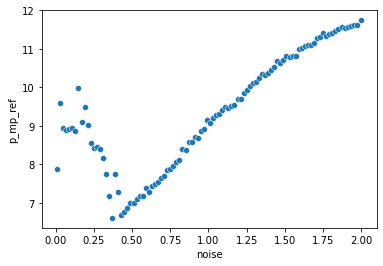

In [38]:
sns.scatterplot(data=temp, x="noise", y="p_mp_ref")

In [40]:
list(range(1,5))

[1, 2, 3, 4]

In [66]:
def one_error_grid(errors, para, figsize=(10, 10)):
    name = {
        1: "POA noise",
        3: "T noise",
        5: "DC V noise",
        7: "DC I noise"
    }

    plt.figure(figsize=figsize)

    sns.set(font_scale=1.5)
    for i, n in enumerate([1, 3, 5, 7]):
        plt.subplot(int("22{}".format(i+1)))
    
        cond_err = df_error(errors, n)
        
        sns.scatterplot(data=cond_err, x="noise", y=para)
        plt.title(name[n])
        #ax.set(title=name[n])

    

In [70]:
!pwd

/Users/XChen9/Codes/Github/pvpro/examples


/Users/XChen9/anaconda3/envs/pvpro/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/XChen9/anaconda3/envs/pvpro/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/XChen9/anaconda3/envs/pvpro/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

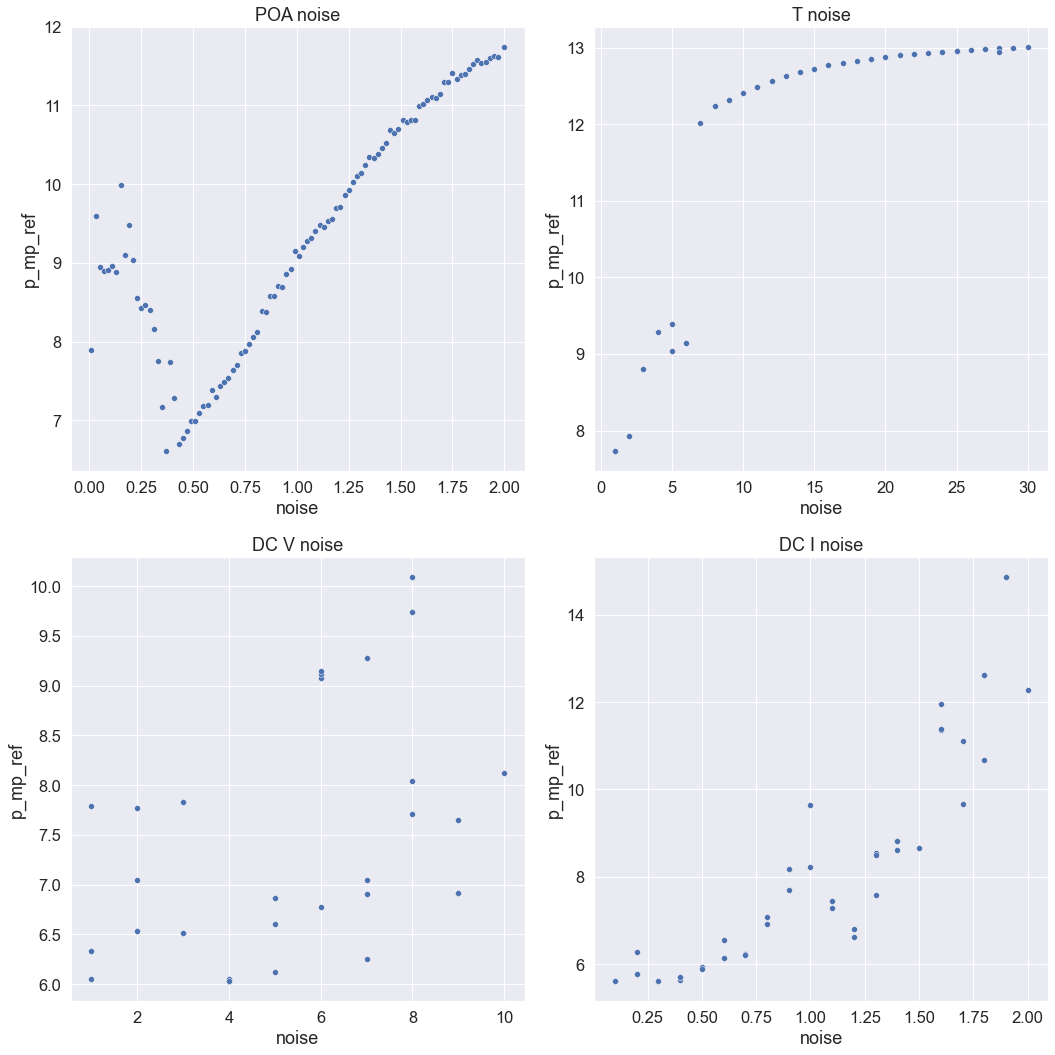

In [71]:
one_error_grid(errors, "p_mp_ref", (15, 15))
plt.tight_layout()
plt.savefig("noise_level/pmp_noise.jpg", dpi=200)

In [47]:
errors = pd.read_pickle("results_synthetic/errors.pkl")
errors.head()

,condition,diode_factor,photocurrent_ref,saturation_current_ref,resistance_series_ref,conductance_shunt_extra,resistance_shunt_ref,nNsVth_ref,i_sc_ref,v_oc_ref,i_mp_ref,v_mp_ref,p_mp_ref
0,poa-0.01-t-0.0-v-0.0-i-0.0,2.434276e-15,0.217920,5.704400e-09,0.236041,0.001151,0.0,5.615139e-15,0.212727,0.609962,0.168478,0.900338,7.893462
1,poa-0.03-t-0.0-v-0.0-i-0.0,2.434276e-15,0.220068,5.219640e-09,0.230031,0.001179,0.0,5.615139e-15,0.217599,0.642163,0.177922,0.977577,9.594003
2,poa-0.05-t-0.0-v-0.0-i-0.0,2.434276e-15,0.232847,5.245535e-09,0.243104,0.001313,0.0,5.615139e-15,0.228592,0.564397,0.182469,0.992962,8.946395
3,poa-0.07-t-0.0-v-0.0-i-0.0,2.434276e-15,0.229920,5.071226e-09,0.231694,0.001287,0.0,5.615139e-15,0.226385,0.563123,0.181696,0.960056,8.896619
4,poa-0.09-t-0.0-v-0.0-i-0.0,2.434276e-15,0.225740,4.437007e-09,0.227810,0.001244,0.0,5.615139e-15,0.222305,0.568964,0.179071,0.944776,8.913141


/var/folders/vj/9f7__9nd5tzcq6nn1cfnfg_w0000gp/T/ipykernel_56476/2129559931.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cond_err["noise"] = pd.to_numeric(cond_n[cond_n_inx])


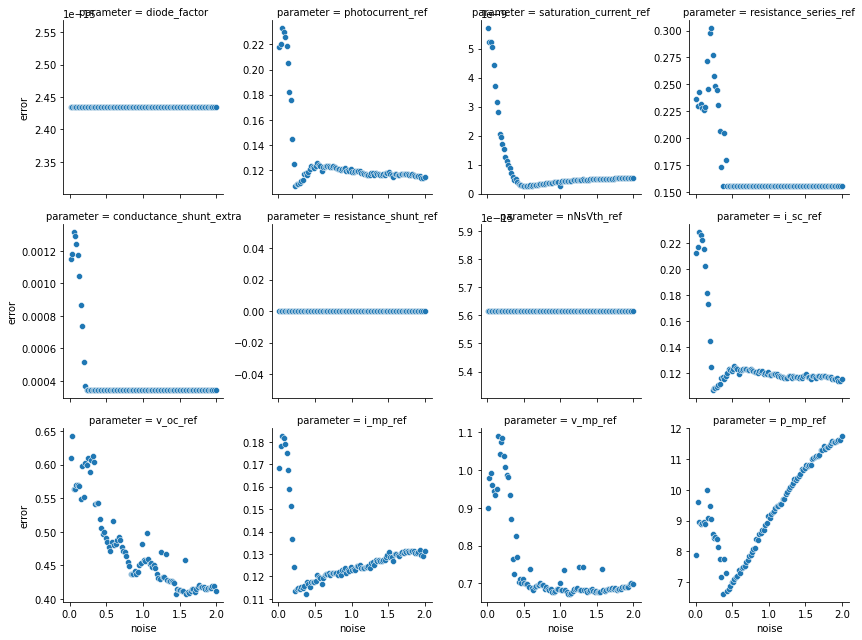

In [30]:
"""
poa: 1
T: 3
V: 5
I: 7
"""

error_grid(errors, 1)